In [3]:
import pandas as pd
import jieba
import jieba.posseg as pseg

from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('waimai_10k.csv')

In [64]:
jieba.lcut(df.review[0])

['很快', '，', '好吃', '，', '味道', '足', '，', '量', '大']

In [65]:
list(pseg.cut(df.review[0]))

[pair('很快', 'd'),
 pair('，', 'x'),
 pair('好吃', 'v'),
 pair('，', 'x'),
 pair('味道', 'n'),
 pair('足', 'a'),
 pair('，', 'x'),
 pair('量', 'n'),
 pair('大', 'a')]

In [66]:
[word for word, flag in pseg.cut(df.review[0]) if flag in ['n','v']]

['好吃', '味道', '量']

In [67]:
df.review.apply(jieba.lcut)

0                           [很快, ，, 好吃, ，, 味道, 足, ，, 量, 大]
1                                 [没有, 送水, 没有, 送水, 没有, 送水]
2                                     [非常, 快, ，, 态度, 好, 。]
3                      [方便, ，, 快捷, ，, 味道, 可口, ，, 快, 递给, 力]
4                             [菜, 味道, 很棒, ！, 送餐, 很, 及时, ！]
                               ...                        
11982             [以前, 几乎, 天天, 吃, ，, 现在, 调料, 什么, 都, 不放, ，]
11983    [昨天, 订, 凉皮, 两份, ，, 什么, 调料, 都, 没有, 放, ，, 就, 放, ...
11984                                  [凉皮, 太辣, ,, 吃不下, 都]
11985                       [本来, 迟到, 了, 还, 自己, 点, ！, ！, ！]
11986    [肉夹馍, 不错, ，, 羊肉, 泡馍, 酱肉, 包, 很, 一般, 。, 凉面, 没, 想...
Name: review, Length: 11987, dtype: object

In [68]:
def cut(x):
    return ' '.join([word for word, flag in pseg.cut(x) if flag in ['n','v']])
# https://gist.github.com/hscspring/c985355e0814f01437eaf8fd55fd7998

df.review.apply(cut)

0                              好吃 味道 量
1                    没有 送水 没有 送水 没有 送水
2                                   态度
3                           味道 可口 递给 力
4                              菜 味道 送餐
                     ...              
11982                          吃 调料 不放
11983         订 凉皮 调料 没有 放 放 麻油 丢 不想 吃
11984                               凉皮
11985                               迟到
11986    肉夹馍 羊肉 酱肉 包 凉面 没 想象 好吃 送餐 倒 是
Name: review, Length: 11987, dtype: object

In [69]:
df['review_cut'] = df.review.apply(cut)

In [70]:
vec = CountVectorizer(min_df=10)
dtm = vec.fit_transform(df.review_cut)


In [71]:
counts = pd.DataFrame(dtm.sum(axis=0))
counts.columns = vec.get_feature_names_out()
counts = counts.T
counts.sort_values(0)

,0
剩菜,10
加上,10
周到,10
香味,10
钢丝,10
...,...
没有,1192
小时,1245
味道,1527
好吃,1536


In [72]:
counts.loc['小时'], counts.loc['涨价']

(0    1245
 Name: 小时, dtype: int64,
 0    10
 Name: 涨价, dtype: int64)

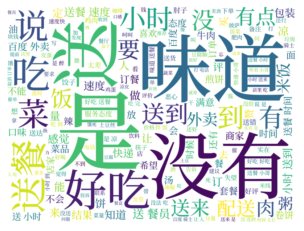

In [73]:
from wordcloud import WordCloud

wordcloud = WordCloud(
    font_path="SourceHanSerifCN-Medium.ttf",
    background_color='white',
    width=800,
    height=600,
    prefer_horizontal=.99,
)
wordcloud = wordcloud.generate('\n'.join(df.review_cut))

plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

In [74]:
from gensim import corpora

texts = df.review_cut.str.split(' ')
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [75]:
from gensim import models
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=50)

In [76]:
from gensim import similarities
index = similarities.MatrixSimilarity(lsi[corpus]) 

In [77]:
doc = "送的太慢了"
vec_bow = dictionary.doc2bow(cut(doc).split(' '))
vec_lsi = lsi[vec_bow]  # convert the query to LSI space
print(vec_lsi)

[(0, 0.28034741311275424), (1, -0.4364517047626672), (2, -0.4846489721221943), (3, 0.3690403416653352), (4, 0.2859831098464513), (5, 0.338867814606147), (6, 0.2328921482054827), (7, -0.047652329632901155), (8, -0.18795831152507936), (9, -0.032084530080973575), (10, 0.03503474325060032), (11, -0.027313081975376144), (12, -0.02019766461722197), (13, -0.0013989544653796259), (14, 0.0028891404694613076), (15, -0.003780972826394944), (16, 0.005188025488489044), (17, 0.009802996608312162), (18, 0.02195067533243686), (19, -0.0016513385143515824), (20, -0.03112326886302916), (21, 0.009186676672909542), (22, -0.021898022137693842), (23, -0.022493699348093785), (24, 0.029470213256634254), (25, 0.004271063771617881), (26, -0.08908723055219205), (27, 0.004903405299852411), (28, -0.03299254696831455), (29, -0.01428828790012279), (30, 0.05871452660783404), (31, -0.042301079417870945), (32, 0.0465607005290022), (33, 0.024056119276838053), (34, -0.007152124713219923), (35, -0.02863925838096086), (36, 

In [78]:
sims = index[vec_lsi]  # perform a similarity query against the corpus
sims = sorted(enumerate(sims), key=lambda item: -item[1])
for doc_position, doc_score in sims:
    print(doc_score, df.review[doc_position])

1.0 挺好吃的不错送的很快
1.0 外送很快，给赞一个～
1.0 非常好送的很快，，，还是热的。
1.0 真的优惠！！送的不慢！！
1.0 挺好吃,送得太快了！
1.0 今天送的挺早。。。。。。
1.0 送的太快了，师傅很辛苦，谢谢了。
1.0 送的好慢啊
1.0 东西不错，就是送的太慢
1.0 太快了，送的！
1.0 送的太快啦
1.0 送的比较慢
1.0 就是送的太慢，但服务不错
1.0 送的慢了点
1.0 送的太早了
1.0 确实挺好吃！就是送的有点儿慢！
1.0 送的超级快！
1.0 送的出乎意料的快！！
1.0 秒送！太快了！
1.0 送的特别快
1.0 送的很快，谢谢很准啊
1.0 送得很快,东西也很好次
1.0 非常好，送得及时
1.0 送的太快了
1.0 服务很好，送的很快，很有礼貌。
1.0 非常好，送的也非常非常快
1.0 挺好吃的送的也比较快
1.0 送的超级慢而且巨难吃！
1.0 点了三样东西，还少送一样
1.0 送的太慢了！！！！
1.0 送的慢还难吃
1.0 送得太慢了
1.0 难吃，送的又慢！
1.0 送的真慢呢
1.0 送了150分钟！
1.0 送的有点儿慢，不过还是挺好吃的。
1.0 送的太早了也不好
1.0 送的太慢了1个半小时
1.0 送的慢，还少送
1.0 送的可乐呢？？
1.0 送的太慢啦
1.0 送的太晚等的着急。
1.0 送的真的很慢
1.0 东西挺好吃,就是送的太慢
1.0 一个，送的太慢了。。。。
1.0 少送个可乐
1.0 又一次晚送
1.0 不错送的很快
1.0 真烂，送的还晚
1.0 太慢了，送了90分钟。
1.0 送歺太慢！
1.0 预计11点24送，现在12点了
1.0 不错，就是送的太慢了
1.0 送的太晚了！
1.0 少送了一瓶加多宝
0.9999998 送的太快也不是好事=,=！
0.9999998 送的这么慢还请假啥。
0.99999976 少送了薯蓉！
0.9999996 送的太慢了，太慢了，太慢了，服务真糟糕
0.99999833 点了两瓶啤酒就送了一瓶
0.99999636 很快，还送了礼物
0.9999801 点的一品锅怎么送的猪手！
0.99998 端午节还送粽子。业界良心啊！很棒
0.99997926 太吊，秒送...
0.99996644 送的太快了，服务很周到
0.99996626

0.40226468 下单一小时后未送到，电话送餐员.称接单太多，没时间取。让我自己电话客服解决。之后致电2次客服后，才派第二个人送。冒冒失失的什么都不知道。送到披萨凉透。可笑的是客服电话追踪：第一个外送员出车祸了，给你带来不便，请谅解。第二天退半价的金额到银行卡。你们就是这样诅咒快递员的啊。嘴太损了。难道实事求是这样难做到吗？
0.40206575 送不到就不要接单好了，上午十点半下单下午一点半才送到，打电话店员态度不应该诚恳点？你还有理了？卷饼味道一般，凉的，像是剩菜。
0.4020005 说好的辣酱呢，我留言了的，居然一点没放，太淡了，能体会只能沾酱油吃的无奈吗？送的饮料也没送，能称赞也就是粥了
0.40191215 碰到最差的店铺！餐点不送上楼。蛋糕没有冰袋，收到已经软化。味道也很糟，丝绒杯用的还是植物奶油。服务差。味道也差…
0.40142006 ❀⚘送༵来༵不༵是༵很༵凉༵了༵但༵味༵道༵还༵是༵不༵错༵的༵⚘❀
0.40140688 送了两个多小时！大家吃饭我工作，大家开工了，我端一碗臭臭的螺狮粉，想想什么感受吧！快递大哥态度很好不停道歉，只能说百度系统流程都太烂，不规划好路线两个小时十单都送不完，就是这结果。说说菜品，粉不错，鸭肠不好一股没处理好的味儿，鸭掌还行，绿豆汤送到都撒了一半。
0.40068555 面的味道还行，送的晚了15分钟汤全洒了不说，送餐的人还多嘴多舌的，这顿饭吃的很心烦
0.40054265 第一次下单付款不接单说无法送达，第二下单又能送了，这接单还要看商家心情？不过吃的还是一如既往的好
0.40015805 差评差评！第一，扁豆和肉没熟,吃完闹肚子,胃疼两天了,第二，必须满三十才送，可选东西又少，一个人吃饭点了套餐就必须点自己不能喝的凉茶了才能凑够！给一颗星是冲着餐盒
0.40011558 卡着点儿送,路线上都把中国地图画出来了，咖啡凉了,还洒了出来,！送到了什么习惯？眼睛一直往屋里瞄来瞄去！百度外卖再见！
0.3998866 菜品好吃，味道正，量足，用料好。快递小哥效率高，服务周到，跑了两趟特意送发票，认真负责，赞一个!
0.39963856 送餐时间延误1个小时，但外送人员态度较好，希望下次能快点儿。
0.3991374 送外卖的把饭放在门口的桌子上就走了，都没有告诉我一下，害得我像傻子似的等着，要不是同事告诉我门口有饭让我

0.019329483 不能再凉了,我点了不要辣，辣辣的青椒会不会太多了…哭昏
0.019299224 不能难吃更多
0.019299224 跟华茂那家完全不能比
0.019299224 太难吃了,一定不能选他家
0.019299224 不能更慢了
0.019291367 送餐时间不准。催单电话根本没人接，也没法取消订单。
0.019247858 太慢，以后不会定了！
0.019242961 我的粥怎么没送过来。,赠送的饮料也没有。没有就不要写在订单了！玩呢？
0.019226402 速度很快。而且我找不到钥匙也耐心等。还安慰我说不着急。人很好。东西很好喝。下次还会买
0.019198293 速递小哥辛苦了，饭菜到手还是烫烫的，在这寒冷的日子，谢谢啦！
0.01915597 卖家很贴心让给点辣油竟然把瓶子都拿来了！,芝士再多些就完美啦
0.019150246 大份的超级大，一个人吃不了。。
0.019139148 送来的汉堡都冷透了，纸袋子都潮坏了，纸包装糊在汉堡上。恶心到了！配送员年纪很大了，打电话送货一直在道歉，也理解啦，但是如果不能快速送货，可能不会再用这个软件了。
0.01908633 12点定的餐两点才到。。。
0.019082136 不错…还挺快…还吃
0.019048195 大牌就是靠谱!
0.019027317 两串红柳，三串肉筋加起来就那么一丁点…呵呵了就…烤串外卖就只能看店家良心了…
0.019009907 1.,等了2个小时,打了大约10个电话,前几次根本没有任何回应只说帮忙问问,后来发飙了才有餐厅回应我。,2.,20多度的天气,东西放在保温箱里，送来都凉了,3.,饮料也洒了,简直不能忍,第一次在黄太吉订餐,从此黄太吉一生黑
0.018988628 挺快，味道一般
0.018980674 从没见过配送员之间要好评的。上来一张口就说给我个好评。凭什么呀。您的餐还没从餐箱里拿出来就要好评！就这服务！还没服务就要好评！凭什么！真差
0.018975832 很快很靠谱
0.018970259 我等了一个半小时才送到，都快上课了根本没机会吃了，打电话想取消订单打了无数次都打不通！！！！
0.018880889 还行吧，划算
0.018869018 生病在家点的餐，份量很大，味道也不错
0.01886015 太慢了。担心无法及时送到，特地提前三小时下单，最

0.008353947 送餐大叔太帅了，速度也挺快，小腿肌肉很发达啊
0.008343945 差评，接单两个多小时没有送餐，打电话也没人接听，更无法取消订单，至今没有给予回复，这是订宵夜的节奏，送来带着锡纸都凉透了，你们都是只上夜班的吗？骗子！！！
0.008321418 这馅料的量，我只有呵呵了
0.008309274 10:25点的。13点10分之后到。,中间电话都打不通。最后我直接不要了
0.008309236 送货慢，订的排骨没了，换了个黄焖鸡，有点辣
0.008308775 送货速度很快，一直定这家，赞
0.008308692 订完餐到给我打电话接餐用了两个多小时，给我打电话接餐到见到外卖小哥用了半个小时，东西东西显然已经冰了，吃个屁啊还？,科科
0.0083084805 11点以前就定的餐，做了1小时48分钟，呵呵，我只想说：拜拜！！！
0.008304914 由于系统问题，订单上留的电话被搞错了，快递迟到1个小时。东西还比较可口，但少了吸管。
0.00830228 时间太长！还少了个汉堡和薯条,最后小哥去店里又取了一趟才吃到
0.008301782 百度骑士人好速度快！
0.008295389 等了好久才送到,真不是一般的慢,比预计晚了降近半个小时,连电话都不打一个
0.008291209 时间太长，面都坨了
0.0082865115 菜挺好吃的，但是速度真心是！！！饿死了好几个人了才吃上饭！
0.008286487 没想到这么好吃，好评！！！
0.008286487 全五星好评，好吃啊
0.008275142 味道可以，但是没有给酱油、醋、辣椒油
0.008273421 又慢又不好吃。。。谁订坑谁
0.008263216 量简直一个少!米饭只有一口!
0.008262727 不是第一次定！正餐时间订都没这么慢过！一个多小时！送来金牌炒饭是给猫吃的呀？饭盒少半盒！佩服！！！
0.00825543 不愧是老字号，点心味道就是好吃啊！骑士送货速度很快，为人和善，必须赞一个！
0.008252408 分量很足，不错，都是肉丁，还有青辣椒，不腻，下次尝尝别的口味的。
0.008236514 额。两个小时送来也就算了，我也认了。可是点的南瓜粥呢？？？？希望给个解释。。。
0.008230447 订了三碗粥，三份分量都不一样坑
0.008227765 超级难吃，而

0.004544875 鸡都没有半只，太坑了！
0.0045427084 好评给快递员！东西一般般……不喜欢，秘制凉皮勉强吃了一半
0.0045343162 速度真快！饭菜好！我喜欢！
0.0045327037 太次了，饭里居然吃出来烟头了，恶心死了，而且饭都是凉的
0.004526626 简直不能更糟糕！！！汤汁流得到处都是，并且图片与实物差太多！纯素卷里根本没有绿色蔬菜
0.004522862 送餐太慢,十点定的,两点才送到，如果不能保证送餐的话就不要搞这么大的活动。披萨味道还行，就是送过来的时候已经软掉了
0.004522752 一看就是年轻人搞得，有青春的味道，不过你那尖椒不要都集中在底部
0.004516374 11点40下的单，14点送到，咖啡全凉，百度外卖用了那么多次，最差的一次体验，再这样，不用了
0.0045134956 太少了。。。根本没吃饱,20元才12个饺子。。。
0.0045125317 非常好喝,一直喜欢,布丁好吃
0.0045116562 每次好像选了要发票，总是给自动取消
0.0045100693 不错，味道挺好。值得点赞。
0.004509999 一个多小时，时间太长了
0.0045076087 饭菜一般，快递不错，赞一个
0.004506441 套餐里没有给彩豆……
0.004502779 海带炖肉里都是肥肉
0.0044987723 点了一份番茄有机菜花送来时汤全部洒在袋子里面了
0.004497093 你确定你做的是京酱肉丝？还是欺负顾客没有吃过？还是因为顾客选择了打折？还是百度没有给你们补差价？米饭还是二次加热过的，明显是剩饭。无语，伤心，不会再订了
0.004487883 我的卤蛋没给。已经不是第一次少给东西了
0.004480484 饺子上粘着虫，怎么吃
0.0044744248 配送员路不熟。凉透了！
0.0044725477 送餐速度太慢，俩小时，不能忍了
0.004471915 这是酸辣粉吗？太难吃了！其他还好！说过的不放醋，还是放了！
0.004467914 很好吃。送货很准时！非常喜欢。赞赞赞
0.0044648084 不是一般的慢等了两个多小时，冷面已经成一坨了，夹着一根面整碗都能提起来…
0.0044631893 送餐速度太慢2个半小时没送到餐
0.0044576013 为什么感觉肉臭臭的…感觉整个人都不太

0.0022264912 超级无敌慢,等了整整三个小时
0.0022244568 样子不是很好但味道不错
0.0022242896 鸭头用的袋子居然还收包装费，速度太慢，打了两个电话还没找到，最后下楼自己取得
0.0022198604 很好吃呀！海带丝再更入味些就完美了！
0.00221258 还能再慢一点嘛！！！！！！！一个半小时！！！！真不愧新店！！
0.0022103214 等了一个小时，超过预期时间，我出门办事都出去不去，谢谢啊，你们好快
0.0022096275 接错单了，时间长了些
0.002206135 冒雨送餐，感谢！
0.0022013201 菜有点辣，菜量挺好，量大。味道挺好。
0.002201235 相当差劲，炒的鸡蛋炒饼感觉都坏啦，牛肉18元就几块太少。木耳的量还可以。
0.00219655 没有沙拉番茄
0.002196126 辣死了,但是送餐速度好快
0.002193213 这家的卷饼很好吃，但是送餐每次都很慢，要一个半小时的样子。不过还挺值得等的，尤其肘子卷和鸡腿卷。不过土豆肉丝卷一般，肉少。
0.0021913925 差差差，不到十一点定的，十二点半才到，整整脱了一个多小时。打电话说到楼下了，三十分钟也没上来，爬楼梯也十几分钟到了吧，
0.002190453 慢的要死，等了一个半小时才到
0.0021898297 太慢啦,然后饭都凉了,很难吃,我发誓就这一次
0.002187606 师傅很辛苦啊，找了一个小时才找到地儿，结果已经到下午了，吃不了了。辛苦师傅了
0.0021844031 粉没有办法吃了
0.00217987 把我点的菜都给忘了,10.30下的单,12点10才到,我能说什么呢
0.0021787016 量太少,价格够贵,差劲
0.0021785186 真的太慢了，迟到一小时，所有菜都凉透了
0.002178096 连筷子都没有也配叫外卖？
0.002177374 菜太难吃了,油太大,肉也不新鲜不会再光顾了,快递员不错！
0.0021714682 比我想象的快啊，才一个多小时，这两天都是两三个小时的。
0.002167986 这次东西没少,但是为什么每次送来的汤都是凉的,昨天是勉强有点温度,今天我的是彻底凉的,你们是把剩的给我送来了么
0.0021665778 外卖的饼有点软了，不过送餐还是比较准时的，一般都在30到50分钟

0.00023196847 慢慢慢慢慢，岂是一个慢能够形容的
0.00023176579 量是真心不敢恭维哇
0.00023100869 孜然鸡丁饭没有上次好吃,而且还提价了一块钱,宫保鸡丁一般
0.00022990699 菜好淡，没有味。就肠还行
0.00022801058 宇宙的味道，很好吃！
0.00022733014 味道还不错，性价比较高
0.00022733014 性价比太低，而且味道一般
0.00022293709 谁点谁上当,吃了一口都快吐了！决没有夸张！
0.00022238493 等待了105分钟，还是在投诉的情况下才送餐
0.00021995138 老板不错，焖面没有了，换了贵点的牛肉热干面，也没有另收钱，味道不错
0.00021920935 多搞活动哦,尖椒土豆丝没有味道。
0.00021814008 差评，送货速度不是一般的满，竟然两个多小时才送到。打客服电话竟然是空号，简直无语。梅菜扣肉不好吃，米饭却是挺不错。
0.00021618255 服务和味道都是不错的
0.00021441543 味道一般了,可能吃腻了
0.00021229032 时间太久了，米线到这里已经烂掉了，送餐太慢
0.00021102786 有点慢了,希望下次加快
0.00020713115 太屎了这小炒肉,淡的要死,全是肥肉
0.00020605512 5块钱一份的鹌鹑蛋居然只有2个。。。
0.00020530331 十点多预定，还是没有准时送到
0.00020106765 超级推荐香菇肉丝～～～～～凉拌木耳味道不错～～～
0.00019871583 东西不错百度外卖太SB
0.00019548181 20元套餐感觉一般般。
0.00019505434 表示售后客服很不错，虽然送错口味让我多等了一个小时，但是味道真心很赞
0.00019497797 巨难吃，鸡丁没几块都在油里泡着，油太大啦！酸辣土豆丝，请问醋在哪里？辣在哪里？不酸也不辣！这两个菜一起点，已经是我多年的习惯，在n家餐馆吃过，只有这家是最差的！
0.00019345991 很快，也好，包装也好，赞赞赞
0.0001894338 希望菜是新鲜的，近期的,清炒油菜，油菜就不如之前。而且有次居然用白菜代替了,都是菜帮子。
0.00018887699 太快了！！简直是神速啊！！！
0.00018571492 酸梅

-0.0008302195 太离谱了，一杯咖啡十二点下单，下午一点半多送到，且杯子那个脏呀，不忍目睹，更可气的是就剩半杯了，有史以来的差评！！！
-0.0008311159 没以前好吃了
-0.0008311159 没以前好吃了，还跟乌龟一样慢死了
-0.0008321153 菜真的很少,可能是主打卷饼所以米法蔬菜拌饭才会这样难吃，肉也很少，基本上菜吃完了还剩下一大半的米没吃呢，不会再订了，太坑人了。
-0.00083329296 应该16点30送到，结果19点多才给我送来！打电话给客服给我个号码让我自己跟配送员联系。配送员态度更恶劣，自己按不响门铃还对我说“快点快点”让我自己出去拿蛋糕！什么玩意儿，再也不会到这家店来买了！
-0.00083424477 量足味儿美！
-0.0008343268 味道一般（纯素蔬菜卷）
-0.00083517144 时间差距太大了……吃饭的心情都等没了
-0.00083740545 不好吃，不像厨师做的，连家常菜不如
-0.00083849765 卷饼很好吃，量也足。但是咱这送餐速度真不敢恭维。10点40订的，一点才送到，再晚点可以做下午茶了
-0.0008397829 怎么说呢，最满意的是包装，哈哈，味道和想象的差好远，饼好硬，哎╮(╯▽╰)╭，不过挺便宜的
-0.00084251486 味道不怎么玩
-0.0008458183 味道还可以，就是等的花儿也谢了，近2小时才送到…
-0.00084702985 菜很好，但是送餐时间略长
-0.00084945746 味道很好，还会光顾
-0.00085451576 不好吃,不是炒菜是咕嘟菜
-0.00085518276 味道不错，送餐人员也很负责，必须赞，
-0.00085735146 全都凉了！！！保温箱是摆设吗？
-0.000857394 菜量很大，满满当当的，味道也还不错。
-0.000857394 菜量太少，味道还可以
-0.000857394 菜量很小，味道一般
-0.00085780816 垃圾，接单配送慢的要死
-0.00085824507 味道不错，超值的
-0.0008625374 送到菜和饭都凉了,哎
-0.0008635834 橙子有一个直接是干的没任何水份了！香蕉里面黑了一根！
-0.0008649118 送餐很及时。,但是炝炒圆白菜没熟，而且感觉像是焯了水就

-0.0027373729 菜的质量挺好,送餐很差味道比一般好些
-0.002742467 烧茄子，怎么还有青椒和西红柿
-0.0027424935 迟到3小时,配送不知道是哪家得,很混乱
-0.002743001 送货很快，经常吃他家的，很棒
-0.0027440637 一直喜欢一直很满意
-0.0027471015 及时更新送餐信息很重要！
-0.0027486472 送餐挺速度的。味道自己吃有点淡。
-0.002751351 太咸了，建议做淡些，给口重的用户配一小包盐
-0.002756397 送餐快，卷饼好吃
-0.002756397 卷饼很好吃，送餐也很快！
-0.0027590531 百度外卖超快,有些菜没了，换的
-0.0027594082 换菜了，说不放辣还放，什么意思
-0.0027600399 剁椒鱼头换了酸菜鱼，有土腥味儿，很不好。豆腐还行～送餐小哥辛苦了。
-0.0027601477 味道不错，挺讲究的，私房豆腐很好吃
-0.0027608175 量不大，不过挺好的，这么便宜哪找去。
-0.0027610445 百度骑士冒雨前来，送餐及时，非常感谢
-0.002765422 没提供筷子，派送员不带零钱，简直奇葩。
-0.0027667684 我要的是炒菜，结果送来的是盖饭！太不负责任了！
-0.002767259 差评！一点菜没有，咖喱猪排饭一点咖喱也没有，只有两块土豆。送餐时间一个小时！催了三次！评价这个界面的送餐时间也是虚假的，根本不是真正送到的时间！
-0.0027685005 好好吃的宇宙卷饼,棒棒哒～送餐速度出乎意料～
-0.0027716542 特别差,送货慢,送到后还漏啦三份,百度这外卖也别做啦,头一次遇到这么差的,打电话给百度快递连个抱歉都没有
-0.002774913 等收到的时候，卤煮是温的，饼是凉的。速度慢。
-0.0027774107 这次我写了我要勺子就给了我筷子，我还特地写了我需要两把勺子还是不给勺子。就不明白了，给个勺子有多难？没有勺子打电话说一声有多难？
-0.0027797765 快递小哥太给力了，从下单到送到只用了半个小时，牛肉面都没有坨，只是豆干收了1元的打包盒的钱却只是用塑料袋装的，好在百度在线支付活动给力，省了好多钱，也无所谓了
-0.002780794 菜不符！而且难吃
-0.0027834186 

-0.0064490438 快递还让我下去接，还说找不到，语气不善，吃东西都没心情了，我要的混沌，给我一份饺子这是搞什么啊
-0.0064507206 很不好吃，不知道为什么
-0.0064591486 终于赶在半价以前把晚餐送来了，实在是“感谢”！饭盒一看就是装盖饭的尺寸，如果是这样就不必多花那几块钱。菜的颜色早已不新鲜，看来是吃了中午的剩菜。除了快递员还知道有些不好意思外，实在没有什么可值得称赞的，放了勾芡这些已然没必要再提了。
-0.006461411 我只能说，鱼豆腐是最好吃的！并且推荐！
-0.006465204 又没送餐具，非要让我们当原始人，上手抓啊？
-0.0064718956 外卖员蛮好的,但是,菜品水太多了
-0.006484216 送餐及时，包装看起来高大上
-0.0064929207 送餐快，我觉得挺好
-0.0064942725 送货的小哥服务态度特别好,煎饼真的很好吃,豆腐脑一般,赞赞赞
-0.006497645 相当好,包装精细,味道好,送餐速度
-0.006522051 虽然送达晚了一点，但是快递员提前打电话告知了缘由，态度非常好，我们也非常理解，雾霾天快递员小哥们不容易哦！表示感谢！好评！
-0.006524795 像是青菜炒肉
-0.006526022 基本没羊肉,备注都不看的嘛,⋯⋯,全是香菜,⋯⋯,我过敏啊！
-0.0065359836 超级慢，配送态度也差，感觉就他家牛逼似的
-0.0065403543 鸡丝凉面太太太难吃啦
-0.0065471386 按我要求的时间送到了，但不是新做的，是冷藏过的，有点失望。
-0.006547805 味道不错，份量够足，速度也快，态度好。
-0.0065514827 百度外卖速度快，态度好。
-0.0065521155 牛肉套餐里边连牛肉都没,不是套餐吗怎么没有其他的连米饭都没有,还那么素,差评
-0.0065557333 东西很少，像半分每次都是这样失望
-0.0065626074 东西略贵,那么一点牛肉26,在超市26能买好大一块酱牛肉
-0.0065675424 打包盒太次了居然还收费，漏了满袋子的油。饭量倒是挺多。
-0.0065702978 配送太慢，东西没收到，就被确认收到
-0.006576431 味道不错，送餐及时，态度很好
-0.0065809246 现在的量明显比以前

-0.0286683 红豆沙喝了几口就拉肚子了
-0.028687567 酸菜白肉中只有少量的白肉,皮蛋豆腐都没有拌,对本次菜品及其不满意
-0.02881351 等了一个半小时不说，商家坐地起价，价格上调，送货的到了没有零钱，真是够了，腰疼的不行的，刚贴上，不知道效果
-0.028833058 非常慢，其中催单也没人理会
-0.028887447 发票打错字了，如何报销？
-0.029027496 怎么一股汽油味？难吃死了,食材也太差了,浪费钱
-0.029120492 特别快！很满意的一次购物
-0.029132739 不是鳕鱼，骗子！
-0.029171918 能准时送达吗？
-0.029202444 下午拉肚子了
-0.029286059 绿豆汤馊了！！！！！！我明天铁定拉肚子！
-0.02941164 一直在订餐还不错好评
-0.029481508 腐竹一股坏了的味道，更重要的是生菜里有毛毛虫，你马勒戈壁的商家，操你姥姥
-0.029508887 十一点半下单，显示十二点四十送达，结果一点半才送到！！
-0.02951527 压根没送到，快递员为了降低送达时间，先点了送达。
-0.029557547 非常一般，还不给够发票
-0.02963198 煎饼不错,麻辣拌素简直黑暗料理
-0.029730905 这一单不错，完全满足需求
-0.029732231 真是让我等上火了，继续差评！！！气死人！！！
-0.029737515 炒饭油，咸，鸡丁也炒咸了，放在饭盒里，应该淡一些
-0.029855581 凉面一般额。。。。。。其他还行
-0.029941408 实在慢得不行
-0.030105356 南瓜羹撒了满口袋，煎饼已经惨不忍睹
-0.030154798 服务很到位，及时联系客户
-0.030180328 番茄贡丸豆花米线以后请叫番茄贡丸米线，好吧？！想给零分差评！！！
-0.03028564 价格略贵，豆浆太少
-0.030340878 世界上最难吃的,羊肉泡馍,卖盐的欠他们家钱。肯定打死的。
-0.03056812 蓝莓山药送来的时候是坏的，打电话回商家反应没有诚意处理，一直说蓝莓本来就是酸的，还让我在电话那头等待了8分钟，最后受不了了，把电话挂掉了
-0.03068044 真是傻缺的一个卖家
-0.030745976 配送很快,就是要了发票但商家没

In [79]:
import cntext as ct

text = '如何看待一网文作者被黑客大佬盗号改文，因万分惭愧而停更。'

ct.readability(text, lang='chinese')

{'readability1': 28.0,
 'readability2': 0.15789473684210525,
 'readability3': 14.078947368421053}

In [80]:
def get_readability(x):
    return ct.readability(x)['readability3']

df['readability'] = df.review.apply(get_readability)

In [81]:
df.sort_values('readability')

,label,review,sentiment,review_cut,readability
3850,1,快！好！牛！,8.667781e-01,牛,0.333333
9453,0,太！慢！了！,2.055062e-01,,0.416667
5075,0,额。。。很难吃,6.118489e-01,额,0.500000
5132,0,不好吃。。。菜太少了。。。。,6.256497e-02,好吃 菜,0.633333
5404,0,好多肥肉。。？？,2.204118e-01,肥肉,0.666667
...,...,...,...,...,...
6693,0,"每次都是一样的慢,就算是提前下单也改变不了什么,迟到了将近俩小时快递员没有一句抱歉只是告诉我...",1.071659e-07,是 就算 是 提前 下单 改变 不了 迟到 小时 快递 没有 抱歉 告诉 别定 体谅 外送员...,91.087719
7159,0,点的吊烧鸡，店家沟通过是吊烧鸽，也很诚实的说肯定没有鸡那么大，我也就嫌麻烦没退，虽然有心理准...,1.391862e-02,吊 烧鸡 店家 沟通 吊烧 鸽 说 肯定 没有 鸡 嫌 没退 有 心理准备 看见 实物 惊呆...,96.550388
3564,1,就在家附近，以前总去吃，可是近两三个月以来菜品没有以前好吃了，大拌菜拌苦菊一类的菜总是很甜，...,9.233115e-08,去 吃 菜品 没有 好吃 大拌菜 拌 菜 估计 是 商家 省事 放在 糖水 泡 炒菜 油 没...,99.550781
11176,0,预计11点44送达，结果12点55才送到，中间催了3次单，打每次都说在路上，走着20分钟骑车...,0.000000e+00,送达 结果 送到 催 单 打 说 走 骑车 送 不到 说 帮 催单 嫌弃 订餐 发现 分有 ...,104.031915


In [82]:
from snownlp import SnowNLP
s = SnowNLP(df.review[1])

s.sentiments



0.0794222106902116

In [83]:
df['sentiment'] = df.review.apply(lambda x: SnowNLP(x).sentiments)

In [84]:
df.groupby('label').sentiment.mean()

label
0    0.236727
1    0.685801
Name: sentiment, dtype: float64

In [85]:
from gensim.models import Word2Vec


model = Word2Vec(sentences=df.review.apply(jieba.lcut), vector_size=50, window=5, min_count=1, workers=4)



In [86]:
model.wv.distance('馒头','好吃')

0.23176896572113037

In [87]:
model.wv.distance('面条','好吃')

0.215007483959198

In [88]:
model.wv.distance('馒头','难吃')

0.25371885299682617

In [89]:
model.wv.most_similar('好吃')

[('新鲜', 0.9478037357330322),
 ('精致', 0.9464708566665649),
 ('好喝', 0.9401863813400269),
 ('包装', 0.9391382336616516),
 ('不怎么样', 0.9374178051948547),
 ('喜欢', 0.9349702000617981),
 ('咸', 0.9349507689476013),
 ('干净', 0.9327588677406311),
 ('足', 0.9318265318870544),
 ('太淡', 0.930666983127594)]

In [90]:
model.wv.doesnt_match(['不好吃','难吃','好吃',])

'好吃'

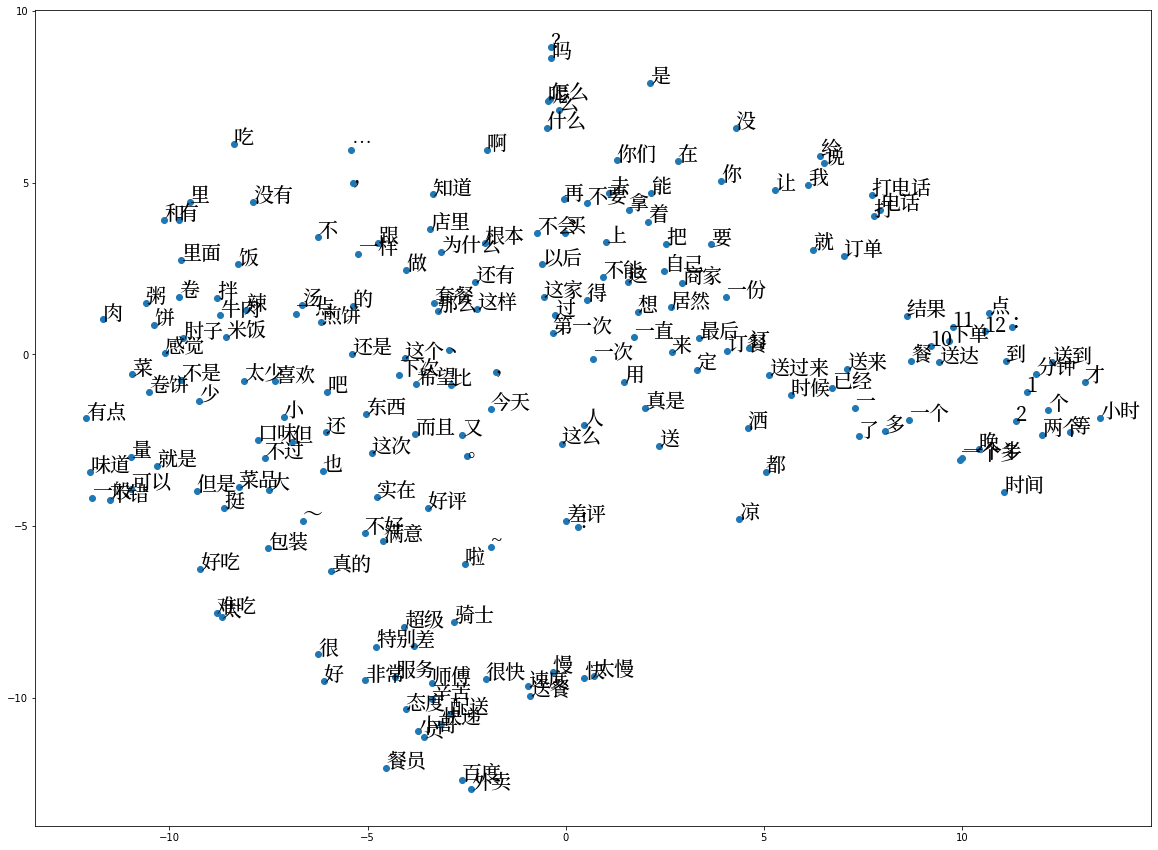

In [91]:
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups
import re
import matplotlib.pyplot as plt
import matplotlib

zhfont = matplotlib.font_manager.FontProperties(
    fname=r'SourceHanSerifCN-Medium.ttf')

n = 200
X = model.wv[model.wv.index_to_key]
X = X[:n, :]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

fig, ax = plt.subplots(figsize=(20, 15))
ax.scatter(X_tsne[:, 0], X_tsne[:, 1])

for i in range(n):
    ax.annotate(model.wv.index_to_key[i],
                 xy=(X_tsne[i, 0], X_tsne[i, 1]),
                 font=zhfont, fontsize=20)

In [92]:
X

array([[ 1.0519593 ,  0.22439066, -0.1915462 , ..., -0.25438946,
         1.5280147 , -0.62398964],
       [ 0.2767714 ,  0.0951103 , -0.8118078 , ..., -1.4753518 ,
         0.5647996 , -0.53781456],
       [ 0.55071723, -0.19794273, -0.42733163, ..., -0.5928794 ,
         0.46437868, -0.34677228],
       ...,
       [ 0.6439959 ,  0.01427274, -0.2559346 , ..., -0.73126024,
         0.48525423, -0.4773446 ],
       [ 0.56421584,  0.1526096 , -0.46734583, ..., -0.54445094,
         0.41788054, -0.45163444],
       [ 0.03366641,  0.13596873, -0.08939118, ..., -0.7198665 ,
         0.58432275, -0.38911095]], dtype=float32)